# This code takes in a .json file from TweetyBERT, then calculates and graphs the song duration across days of recording. Then, It figures out and graphs how often syllables show up across each day of recording.

### Load the .json file here, correct the dates, etc.

In [9]:
import json
import pandas as pd
import ast
from datetime import datetime

class temp:
    def __init__(self):
        # Define the path to the JSON file
        #recording_file_path_name = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/USA5509_decoded_database.json'
        recording_file_path_name = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/USA5336_decoded_database.json'

        # Read the JSON file
        print(f"Reading JSON file: {recording_file_path_name}")
        with open(recording_file_path_name, 'r') as f:
            decoder_data = json.load(f)['results']  # Adjusted to extract the 'results' key

        # Print the total number of songs (assuming each item in 'results' is a song)
        print(f"Total songs in JSON: {len(decoder_data)}")

        # Convert to DataFrame
        decoder_dataframe = pd.DataFrame(decoder_data)
        decoder_dataframe['syllable_onsets_offsets_ms'] = decoder_dataframe['syllable_onsets_offsets_ms'].apply(self.parse_json_safe)
        decoder_dataframe['syllable_onsets_offsets_timebins'] = decoder_dataframe['syllable_onsets_offsets_timebins'].apply(self.parse_json_safe)

        self.dataframe = decoder_dataframe

    def return_dataframe(self):
        return self.dataframe


    def parse_json_safe(self, s):
            """
            Safely parse a string representation of a JSON object.
            Handles extra quotes and converts single quotes to double quotes.
            """
            if isinstance(s, dict):
                return s  # If it's already a dictionary, return it as is
            
            if pd.isna(s):
                return {}
            
            # Remove surrounding single quotes
            s = s.strip()
            if s.startswith("''") and s.endswith("''"):
                s = s[2:-2]
            elif s.startswith("'") and s.endswith("'"):
                s = s[1:-1]
            
            if not s:
                return {}
            
            try:
                # First, attempt to parse using json
                s_json = s.replace("'", '"')
                return json.loads(s_json)
            except json.JSONDecodeError:
                try:
                    # If json fails, attempt using ast.literal_eval
                    return ast.literal_eval(s)
                except (ValueError, SyntaxError) as e:
                    print(f"Error parsing string: {s}\nError: {e}")
                    return {}
    
TEMP = temp()

decoder_dataframe = TEMP.return_dataframe()

print(decoder_dataframe.head)


Reading JSON file: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/USA5336_decoded_database.json
Total songs in JSON: 26327
<bound method NDFrame.head of                                        file_name  song_present  \
0       USA5336_45227.23963928_10_28_6_39_23.wav         False   
1      USA5336_45227.39102237_10_28_10_51_42.wav          True   
2        USA5336_45227.25697248_10_28_7_8_17.wav         False   
3       USA5336_45227.30773984_10_28_8_32_53.wav         False   
4        USA5336_45227.32531395_10_28_9_2_11.wav          True   
...                                          ...           ...   
26322   USA5336_45313.52697743_1_22_14_38_17.wav         False   
26323     USA5336_45313.35644878_1_22_9_54_4.wav         False   
26324   USA5336_45313.60735065_1_22_16_52_15.wav         False   
26325   USA5336_45313.42821550_1_22_11_53_41.wav         False   
26326    USA5336_45313.33291999_1_22_9_14_51.wav         False   

                    

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import json

# Load the CSV and JSON creation_date data
save_output_to_this_file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/outputs'
# USE IF THE DECODER OUTPUT A CSV FILE:
#recording_file_path_name = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/DECODER_csvs_and_jsons/USA5509_decoded.csv'
#decoder_dataframe = pd.read_csv(recording_file_path_name)
#USE IF THE DECODER OUTPUT IS A .JSON FILE:
# recording_file_path_name = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/DECODER_sham_lesions/USA5271_decoded.json'
# print(f"Reading JSON file: {recording_file_path_name}")
# with open(recording_file_path_name, 'r') as f:
#     decoder_data = json.load(f)['results']  # Adjusted to extract the 'results' key
# # Convert to DataFrame
# decoder_dataframe = pd.DataFrame(decoder_data)

path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/USA5336_creation_data.json'


with open(path_to_json_file_with_dates, 'r') as f:
    json_data = json.load(f)
    # Extract surgery date and format it
json_surgery_date = json_data['treatment_date']  # Assuming single treatment date
date_obj = datetime.strptime(json_surgery_date, "%Y-%m-%d")
surgery_date = date_obj.strftime("%Y.%m.%d")  # Adjust to year-first format for consistency
print(f"Surgery date: {surgery_date}")
# Extract subdirectory creation dates from JSON data
subdirectory_dates = {subdir: data['subdirectory_creation_date'] for subdir, data in json_data['subdirectories'].items()}


# Function to extract date, time, and animal_id from the file name
def find_recording_dates_and_times(recording_file_path_name):
    try:
        file_name = recording_file_path_name.split('/')[-1]
        split_file_name_by_underscores = file_name.split('_')
        animal_id = split_file_name_by_underscores[0]
        month = split_file_name_by_underscores[2].zfill(2)
        day = split_file_name_by_underscores[3].zfill(2)
        date = f"{month}.{day}"
        hour = split_file_name_by_underscores[4].zfill(2)
        minute = split_file_name_by_underscores[5].zfill(2)
        second = split_file_name_by_underscores[6].replace('.wav', '').zfill(2)
        return animal_id, date, hour, minute, second
    except IndexError:
        print(f"Error: Unexpected format in file name {recording_file_path_name}")
        return None, None, None, None, None

# Function to update the date with year from the JSON file
def update_date_with_year(row, subdirectory_dates):
    month_day = row['Date']
    month = month_day.split('.')[0]
    for subdir, date in subdirectory_dates.items():
        year, json_month, json_day = date.split('-')
        if json_month == month:
            # Return the date in the format YYYY.MM.DD
            return f"{year}.{month_day}"
    return None

# Function to create a table and filter data where song_present is True
def make_table(input_data_frame, subdirectory_dates):
    only_song_data = input_data_frame[input_data_frame['song_present'] == True].reset_index(drop=True)
    num_files_with_song = only_song_data.shape[0]
    
    organized_data_frame = only_song_data.copy()
    organized_data_frame['Animal ID'] = [None] * num_files_with_song
    organized_data_frame['Date'] = [None] * num_files_with_song
    organized_data_frame['Hour'] = [None] * num_files_with_song
    organized_data_frame['Minute'] = [None] * num_files_with_song
    organized_data_frame['Second'] = [None] * num_files_with_song

    for i, row in only_song_data.iterrows():
        recording_file_path_name = row['file_name']
        try:
            animal_id, date, hour, minute, second = find_recording_dates_and_times(recording_file_path_name)
            organized_data_frame.at[i, 'Animal ID'] = animal_id
            organized_data_frame.at[i, 'Date'] = date
            organized_data_frame.at[i, 'Hour'] = hour
            organized_data_frame.at[i, 'Minute'] = minute
            organized_data_frame.at[i, 'Second'] = second
        except Exception as e:
            print(f"Error processing file {recording_file_path_name}: {e}")
            continue

    # Apply the year correction to the date
    organized_data_frame['Date'] = organized_data_frame.apply(lambda row: update_date_with_year(row, subdirectory_dates), axis=1)
    
    # Convert the updated 'Date' column to a proper datetime object for further handling
    organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], format='%Y.%m.%d', errors='coerce')
    
    print(f"First rows of organized_data_frame with updated dates: {organized_data_frame.head(3)}")
    return organized_data_frame

# Generate the organized data table
organized_data_frame = make_table(decoder_dataframe, subdirectory_dates)

# Find the unique dates from the recording
def find_unique_recording_dates(data_frame):
    # Extract the unique values from the 'Date' column
    unique_dates = data_frame['Date'].dt.strftime('%Y.%m.%d').unique()  # Convert back to string for display purposes
    return unique_dates

# Example usage
unique_dates = find_unique_recording_dates(organized_data_frame)
print("Unique recording dates:", unique_dates)

# ### Clean syllable labels formatting, then find the unique syllable labels in the dataframe
# def clean_and_convert_to_dict(row):
#     try:
#         # Strip leading and trailing single quotes and whitespace
#         row_cleaned = row.strip("''").strip()
#         # Replace single quotes with double quotes for valid JSON syntax
#         row_cleaned = row_cleaned.replace("'", '"')
#         # Convert the cleaned string to a dictionary
#         return json.loads(row_cleaned)
#     except json.JSONDecodeError as e:
#         print(f"JSON decoding failed for row: {row}\nError: {e}")
#         return None  # Return None or some default value if decoding fails

# Apply the function to all rows in the 'syllable_onsets_offsets_ms' column
organized_data_frame['syllable_onsets_offsets_ms_dict'] = organized_data_frame['syllable_onsets_offsets_ms']

# Now 'syllable_onsets_offsets_ms_dict' contains the cleaned and converted dictionaries
# Create a set to store all unique syllable labels
unique_syllable_labels = set()

# Iterate through each row in the 'syllable_onsets_offsets_ms_dict' column
for row in organized_data_frame['syllable_onsets_offsets_ms_dict']:
    if row:  # Check if the row is not None or empty
        # Add the keys (syllable labels) to the set
        unique_syllable_labels.update(row.keys())

# Convert the set to a sorted list (optional, for easier viewing)
unique_syllable_labels = sorted(unique_syllable_labels)

# Print or return the unique syllable labels
print("Unique syllable labels:", unique_syllable_labels)


Surgery date: 2024.01.23
First rows of organized_data_frame with updated dates:                                    file_name  song_present  \
0  USA5336_45227.39102237_10_28_10_51_42.wav          True   
1    USA5336_45227.32531395_10_28_9_2_11.wav          True   
2   USA5336_45227.44583702_10_28_12_23_3.wav          True   

                          syllable_onsets_offsets_ms  \
0  {'9': [[0.0, 113.33333333333334], [9644.126984...   
1  {'14': [[0.0, 307.61904761904765]], '16': [[30...   
2  {'16': [[0.0, 1605.5555555555557], [3157.14285...   

                    syllable_onsets_offsets_timebins Animal ID       Date  \
0  {'9': [[0.0, 42], [3573.9999999999995, 4005]],...   USA5336 2023-10-28   
1  {'14': [[0.0, 114]], '16': [[114.0, 149]], '3'...   USA5336 2023-10-28   
2  {'16': [[0.0, 595], [1170.0, 1250], [1848.0, 2...   USA5336 2023-10-28   

  Hour Minute Second  
0   10     51     42  
1   09     02     11  
2   12     23     03  
Unique recording dates: ['2023.10.28' '2024.0

## This part finds and graphs the song durations (not the phrase durations :) 

In [11]:
syllable_onsets_offsets = organized_data_frame['syllable_onsets_offsets_ms_dict'][10]
print(organized_data_frame['syllable_onsets_offsets_ms_dict'][0])

# Initialize min and max values
min_onset = float('inf')
max_offset = float('-inf')

# Loop through each syllable's onset/offset list
for times in syllable_onsets_offsets.values():
    for onset, offset in times:
        if onset < min_onset:
            min_onset = onset
        if offset > max_offset:
            max_offset = offset

# Print the results
print("Minimum Onset:", min_onset)
print("Maximum Offset:", max_offset)
song_duration = max_offset - min_onset
print(f"Song Duration: {song_duration}")

{'9': [[0.0, 113.33333333333334], [9644.126984126984, 10807.142857142859]], '8': [[113.33333333333334, 1311.4285714285716]], '6': [[1311.4285714285716, 1605.5555555555557], [10807.142857142859, 10915.079365079366]], '15': [[1605.5555555555557, 2787.4603174603176], [6276.507936507937, 8041.269841269842]], '18': [[2787.4603174603176, 2884.603174603175], [8095.238095238095, 8133.015873015874]], '12': [[2884.603174603175, 3267.777777777778], [8151.904761904762, 8813.015873015873]], '0': [[3267.777777777778, 4948.88888888889]], '11': [[4948.88888888889, 6276.507936507937]], '17': [[8041.269841269842, 8076.349206349207]], '16': [[8076.349206349207, 8095.238095238095], [8133.015873015874, 8151.904761904762], [8813.015873015873, 8883.174603174604], [9501.111111111111, 9644.126984126984]], '3': [[8883.174603174604, 9501.111111111111]]}
Minimum Onset: 0.0
Maximum Offset: 6808.0952380952385
Song Duration: 6808.0952380952385


In [12]:
# Iterate over each row of the organized_data_frame
# Initialize a list to store song durations for each row
song_durations = []

# Loop through each row in the organized_data_frame
for index, row in organized_data_frame.iterrows():
    # Extract the syllable onsets/offsets dictionary for the current row
    syllable_onsets_offsets = row['syllable_onsets_offsets_ms_dict']
    
    # Initialize min and max values for each row
    min_onset = float('inf')
    max_offset = float('-inf')
    
    # Loop through each syllable's onset/offset list
    for times in syllable_onsets_offsets.values():
        for onset, offset in times:
            if onset < min_onset:
                min_onset = onset
            if offset > max_offset:
                max_offset = offset
    
    # Calculate the song duration and append it to the list
    song_duration = max_offset - min_onset
    song_durations.append(song_duration)

# Add the song_duration list as a new column in the organized_data_frame
organized_data_frame['song_duration'] = song_durations
# Use .head() to show the first few rows of the specified columns
print(organized_data_frame[['Date', 'syllable_onsets_offsets_ms_dict', 'song_duration']].head())


        Date                    syllable_onsets_offsets_ms_dict  song_duration
0 2023-10-28  {'9': [[0.0, 113.33333333333334], [9644.126984...   10915.079365
1 2023-10-28  {'14': [[0.0, 307.61904761904765]], '16': [[30...    2021.111111
2 2023-10-28  {'16': [[0.0, 1605.5555555555557], [3157.14285...    8383.968254
3 2023-10-28                 {'13': [[0.0, 8.095238095238095]]}       8.095238
4 2023-10-28  {'16': [[0.0, 2344.920634920635], [3650.952380...    8238.253968


## Graph the song durations for each day

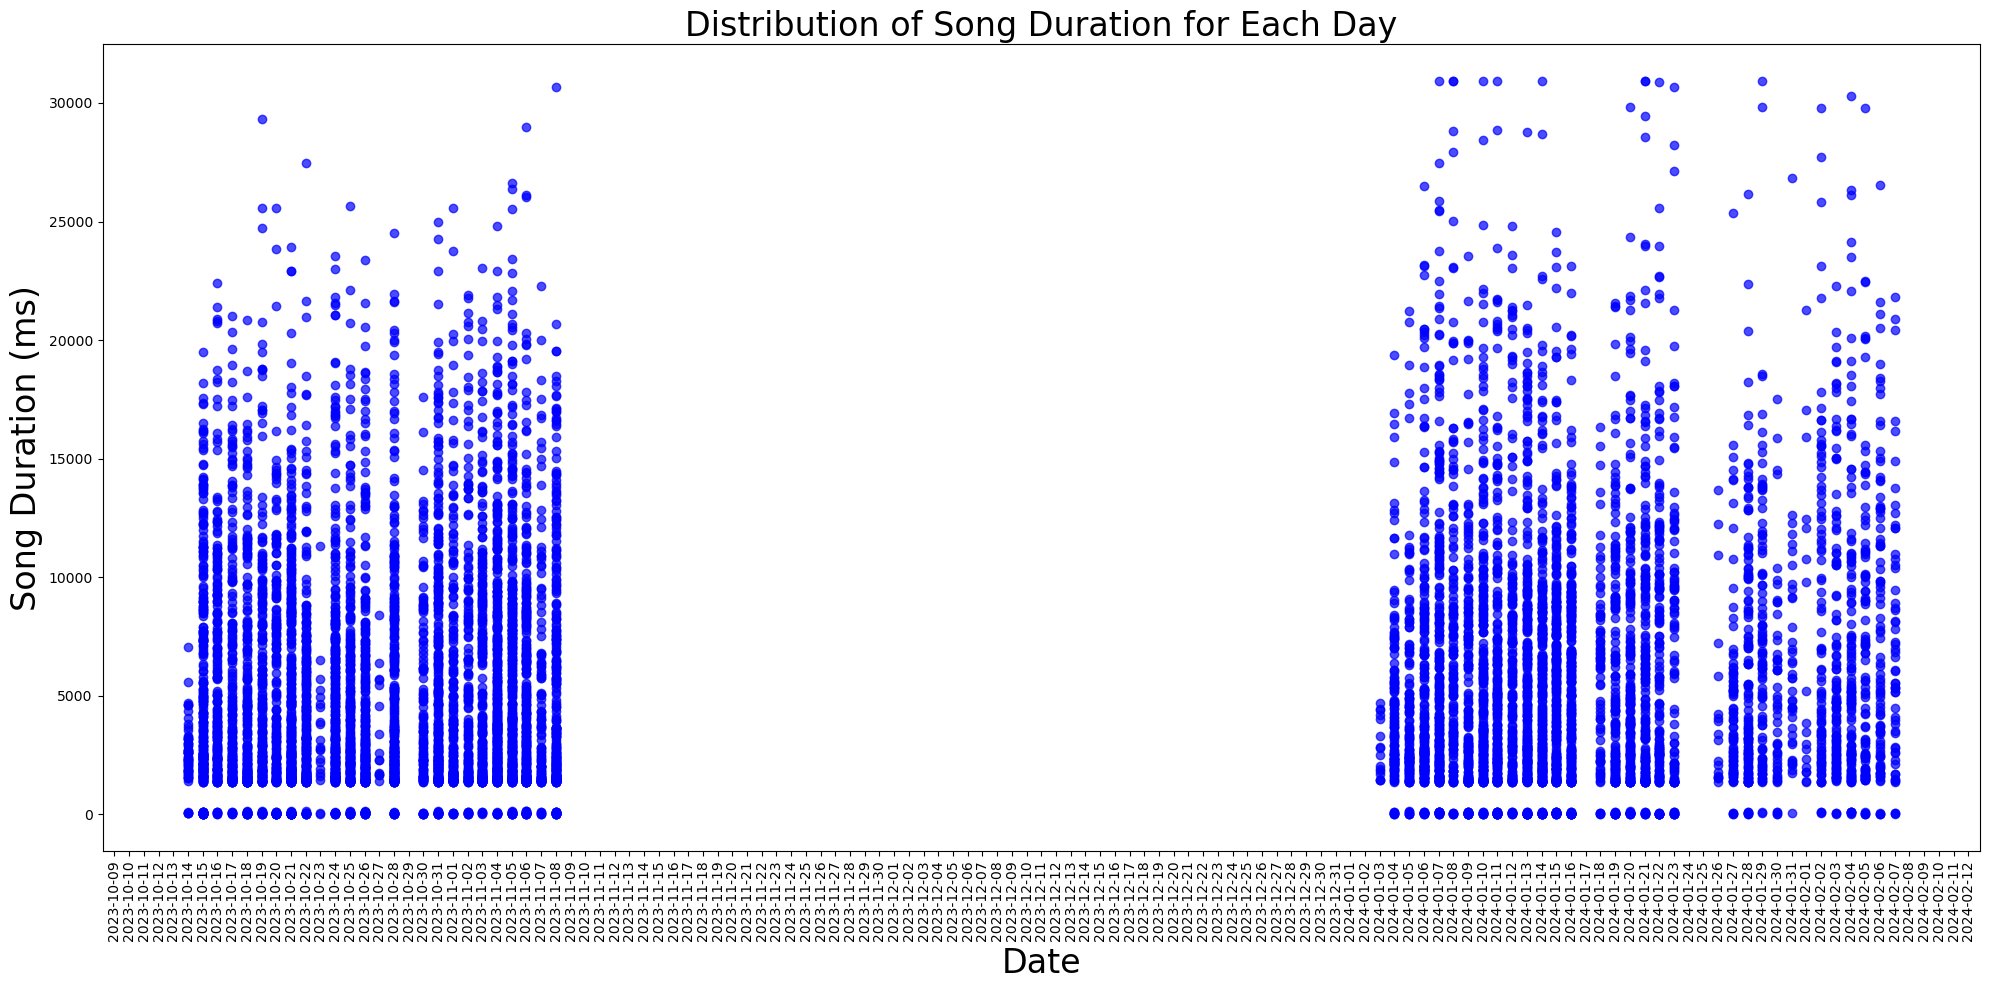

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Find the minimum and maximum date of recording
min_date = organized_data_frame['Date'].min()
max_date = organized_data_frame['Date'].max()

# Generate a date range with a daily frequency from min_date to max_date
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Create scatter plot with all points in blue
plt.figure(figsize=(20, 10))

# Loop through each date in the range and check if there is data for that date
for current_date in all_dates:
    # Filter data for the current date
    daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
    
    # If there is data, plot the song_duration for that date in blue
    if not daily_data.empty:
        plt.scatter(daily_data['Date'], daily_data['song_duration'], color='blue', alpha=0.7)

# Configure plot with labels, title, and an x-tick for every day in the date range
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Song Duration (ms)', fontsize = 24)
plt.title('Distribution of Song Duration for Each Day', fontsize  =24)
plt.xticks(ticks=all_dates, labels=[date.date() for date in all_dates], rotation=90)

# Ensure all dates are displayed
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Locator for each day on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format x-axis labels
plt.tight_layout()
plt.show()


### Group by breeding season vs. non-breeding season

<Figure size 1000x600 with 0 Axes>

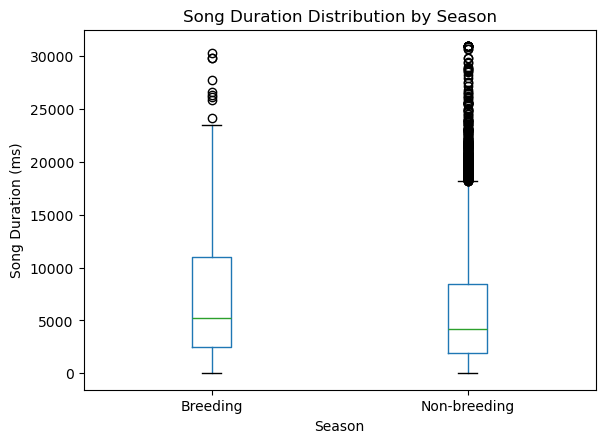

Mann-Whitney U Test Statistic: 3485489.0
P-Value: 5.5852613503458275e-09


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Assuming 'organized_data_frame' already exists and contains 'Date' and 'song_duration' columns

# Define the breeding and non-breeding months
breeding_months = [2, 3, 4, 5, 6]      # February to June
non_breeding_months = [10, 11, 12, 1]  # October to January

# Create a new column 'Season' based on the month of each date
organized_data_frame['Season'] = organized_data_frame['Date'].dt.month.apply(
    lambda x: 'Breeding' if x in breeding_months else ('Non-breeding' if x in non_breeding_months else 'Other')
)

# Filter the DataFrame to include only breeding and non-breeding seasons
filtered_data = organized_data_frame[organized_data_frame['Season'].isin(['Breeding', 'Non-breeding'])]

# Create a box and whisker plot
plt.figure(figsize=(10, 6))
filtered_data.boxplot(column='song_duration', by='Season', grid=False)
plt.title(f'Song Duration Distribution by Season')
plt.suptitle('')  # Suppress the automatic title
plt.xlabel('Season')
plt.ylabel('Song Duration (ms)')
plt.show()

# Separate the song durations by season
breeding_durations = filtered_data[filtered_data['Season'] == 'Breeding']['song_duration']
non_breeding_durations = filtered_data[filtered_data['Season'] == 'Non-breeding']['song_duration']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(breeding_durations, non_breeding_durations, alternative='two-sided')

# Output the test results
print("Mann-Whitney U Test Statistic:", statistic)
print("P-Value:", p_value)


# Make a heat map of how often syllables show up in song here instead: